# Data Science ISM: The Recipe for a winning Basketball Team 

What makes a basketball team win a championship? The weather? The connection the teammates have? The volume with which the crowd chants their names? Perhaps all these things play a part into whether a particular player sinks that 3 that puts them ahead. However, it's a bit difficult to consider all those variables, so I'll be using statistics that have been known to provide meaningful information on basketball teams. 

<img src="Photos/MJ_Pic.jpg" style="height: 250px; width:150px;"/>

First I will analyze the years in which two basketball teams won the championship. One is the Chicago Bulls from the 90s, and the other is the 2010s Golden State Warriors. Both teams were at one point dominant powerhouses. By using k-means clustering, we can determine what kind of players exist in these teams. 

From this, a coach who is trying to build a team like the Chicago Bulls or the Golden State warriors, or any other team in general, can use this to find what players they have that fit the requirement, and which ones they should exchange/trade. 

The  packages used are: 

1. sklearn
2. pandas
3. os
4. numpy
5. BeautifulSoup
6. matplotlib
7. random

All of this was run on ubuntu 22.04 LTS. 

# Web Scraping

In [20]:
# Web Scraping

import os
# # gets you the data and stores it in the Storage file 
# # This is so we dont DDoS the website

import requests
# Teams = ["CHI", "GSW"] # A list of the TeamName= 1

def WebScraper(years, TeamName): 
    url_start = "https://www.basketball-reference.com/teams/" + TeamName + "/{}.html" # url we are concerned with
    for year in years: 
        url = url_start.format(year)
        dir =  "Storage/" + TeamName +"/{}.html".format(year)
        if os.path.exists(dir): # if file exists, no need to request again
            print("Already loaded the data")
        else: 
            if os.path.exists("Storage/" + TeamName) == False:  # if it doesn't exist, we requrest 
                os.makedirs("Storage/" + TeamName)
            data = requests.get(url)
            f = open("Storage/" + TeamName + "/{}.html".format(year), "w+", encoding="utf-8")
            f.write(data.text)
            print("New File Added")


In [64]:
# Select dataframe based on the team name 
# Adding a year column so we know which year the players are done

import pandas as pd 
from bs4 import BeautifulSoup

def GetTeamData(TeamName, years):  # Gets stats for a given Team Code and a list of years. 
    pergame_table = []
    for i in years:
        if os.path.exists("Storage/" + TeamName +"/{}.html".format(i)) == False: # if the file isn't downloaded, get it. 
            WebScraper([i], TeamName) 
        with open("Storage/" + TeamName +"/{}.html".format(i), encoding = "utf-8") as f:  
            page = f.read()
            soup = BeautifulSoup(page, "html.parser") # creates a parser class that will help us extract the html code from the page
            pergame = soup.find(id="per_game") # Reads data from the per_game id. 
            pd.read_html(str(pergame))[0]
            df = pd.read_html(str(pergame))[0]
            df.insert(0, "Year", i)
            # append the data frame to a list so that we have a list of dataframes for the pergame data
            pergame_table.append(df)
    # BigData = pd.concat(pergame_table) # a variable that stores the data for every table. 
    return pergame_table

# returns a list of dataframes where each element is the stats for that team for that particular year.

These are the different stats that we now have access to: 
 
 Index(['Year', 'Rk', 'Unnamed: 1', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS/G'],
      dtype='object')

In [22]:
# Function to easily find the relavent stats that are required and return it as a dataframe

# This function isn't really used later, but might be useful for future
def FindStats(df): 
    names = df["Unnamed: 1"]
    Steals = df["STL"]
    Assist = df["AST"]
    Blocks = df["BLK"]
    pointsPerGame = df["PTS/G"]
    Rebounds = df["TRB"]
    year = df["Year"]
    dict = {"Year": year, "Names": names, "Steals": Steals , "Assists": Assist, "Points":pointsPerGame,
     "Blocks": Blocks, "Rebounds": Rebounds}
    return pd.DataFrame(dict)

# Lets plot the data where it's easy 

# lists out the stats of a particular player
def PlayerData(name, pergame_table): # Takes in the player name and a list of dataframes
   pg = pergame_table[0]
#    pg = pergame_table
   res = pg.loc[pg['Unnamed: 1'] == name] # find the locations where the name is
   for i in range(1, len(pergame_table)):
      pg = pergame_table[i]
      a = pg.loc[pg['Unnamed: 1'] == name] 
      res = pd.concat([res, a])         # return it
   return res # returns the ones with all the values in them 
   

# The below code can generate a list for the stats of a particular player

# n = ChicagoBullsData[0] # get the first list
# NameList = n["Unnamed: 1"] # get the first stats: 

# playerlist = []
# for i in NameList: 
#    playerlist.append(PlayerData(str(i), ChicagoBullsData))

In [23]:
# clustering algorithm
import pandas as pd
import matplotlib.pyplot as plt 
import numpy
from sklearn.cluster import KMeans

def GetClusters(TeamName, A, plot = False): 
    # Choses the three stats we need
    dict = {"Names:": A["Names"], "Points": A["Points"], "Assists": A["Assists"],  "Rebounds": A["Rebounds"]}
    df = pd.DataFrame(dict)

    # zip them and apply the clustering algorithm
    X = list(zip(A["Points"],A["Assists"], A["Rebounds"]))
    km = KMeans(5) # number of clusters is 5 as 5 basketball players
    clusts = km.fit_predict(X)

    if plot == False:  # This is if we don't need to plot the actual 
        return km.cluster_centers_, clusts

    else:  # plot the data
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(km.cluster_centers_[:, 0],
                    km.cluster_centers_[:, 1],
                    km.cluster_centers_[:, 2],
                    s = 250,
                    marker='o',
                    c='red',
                    label='centroids')
        scatter = ax.scatter(df['Points'],df['Assists'], df['Rebounds'],
                            c=clusts,s=20, cmap='winter')

        ax.set_xlabel("Points")
        ax.set_ylabel("Assists")
        ax.set_zlabel("Rebounds")
        ax.set_title("Clustering for " + str(TeamName))
        
        return km.cluster_centers_, clusts
        

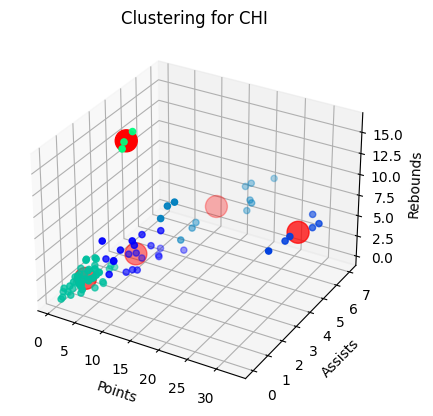

In [65]:
# getting data for the Chicgao bulls

TeamName = "CHI"
years = [1991, 1992, 1993, 1996, 1997, 1998] 
Data = GetTeamData(TeamName, years)
BigData = pd.concat(Data) # A large dataframe with the stats for all the years combined into one
TeamStats = FindStats(BigData)
posCHI, clustsCHI = GetClusters(TeamName, TeamStats, plot = True) 

df = BigData
dfbulls = TeamStats

# add a label so we can find which player belongs to which cluster
df["Label"] = clustsCHI
dfbulls["Label"] = clustsCHI

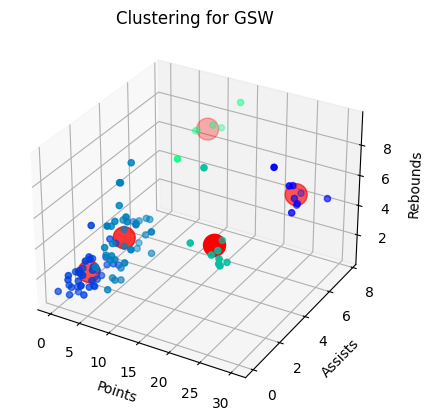

In [52]:
# same thing for a different team

TeamName = "GSW"
years = [2015, 2016, 2017, 2018, 2019, 2022]
Data = GetTeamData(TeamName, years)
BigData = pd.concat(Data)
TeamStats = FindStats(BigData)
dfGSW = TeamStats
posGSW, clustsGSW = GetClusters(TeamName, TeamStats, plot = True) 
dfGSW["Label"] = clustsGSW 

In [26]:
import numpy as np
nposCHI = [None] * 5

def dist(X, Y):  # displacement formula for three dimensions
    return np.sqrt((X[0] - Y[0])**2 + (X[1] - Y[1])**2 + (X[2] - Y[2])**2)

distList = [] # a list of the displacement for every entry of one team to the other team
for i in posCHI: 
    for j in posGSW: 
        distList.append([i, j, dist(i, j)])

NewList = []

for i in range(5):  # finding the minimum displacement between two clusters
    first = np.array(distList[i*5: (i+1) * 5], dtype = "object")
    m = np.amin(first[:, 2])
    idx = np.where(first[:, 2] ==  m)[0]
    NewEntry = [(first[:, 0][idx], first[:, 1][idx], first[:, 2][idx])]
    if NewEntry[0] not in NewList: # don't let the two clusters overlap
        NewList.append(NewEntry[0])
    else: 
        print("No comparable player") # this condition has not yet been triggered. 

/tmp/ipykernel_42633/2382726645.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if NewEntry[0] not in NewList: # don't let the two clusters overlap


In [40]:
# creating arrays of the different data 

c = []
for i in NewList: 
    a, b, d = i 
    c.append([a[0], b[0], d[0]])

bullsDat = []
gswDat = []
diffDat = []

for i in range(5): 
    bullsDat.append(c[i][0])
    gswDat.append(c[i][1])
    diffDat.append(c[i][2])

bullsDat = np.array(bullsDat)
gswDat = np.array(gswDat)
diffDat = np.array(diffDat) 

In [41]:
dict = {"bPoints": bullsDat[:, 0], "gPoints": gswDat[:, 0], "bAssists": bullsDat[:, 1], 
"gAssists": gswDat[:, 1], "bRebounds": bullsDat[:, 2], "gRebounds": gswDat[:, 2]}

In [42]:
sorted = pd.DataFrame(dict)
sorted["Name"] = [0, 1, 2, 3, 4]
sorted["Distance"] = diffDat
A = sorted

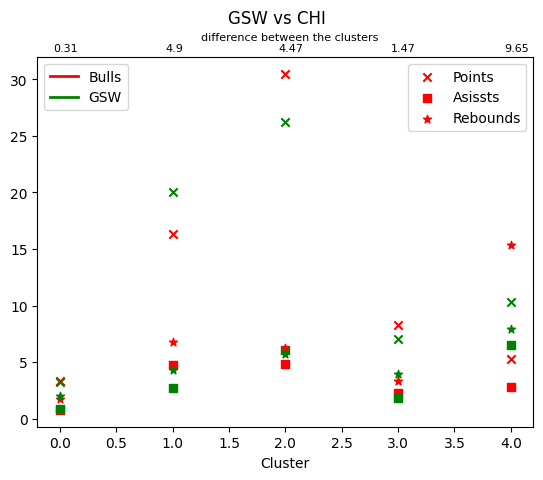

In [45]:
# plotting the data 

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color= "red", lw=2),
                Line2D([0], [0], color= "green", lw=2)]

fig, ax = plt.subplots()

plt.scatter( A["Name"], A["bPoints"], color = "red", marker = "x", label = "Points")
plt.scatter( A["Name"], A["gPoints"], color = "green", marker = "x")

plt.scatter( A["Name"], A["bAssists"], color = "red",marker = "s", label = "Asissts")
plt.scatter( A["Name"], A["gAssists"], color = "green", marker = "s")

plt.scatter( A["Name"], A["bRebounds"], color = "red",marker = "*", label = "Rebounds")
plt.scatter( A["Name"], A["gRebounds"], color = "green",marker = "*")

plt.xlabel("Cluster")
plt.suptitle("GSW vs CHI")
first_legend = plt.legend(loc = 'upper right')
plt.gca().add_artist(first_legend)
plt.legend(custom_lines, ['Bulls', 'GSW'], loc = 'upper left')
plt.text(1.25, 33.5, "difference between the clusters", fontsize = 8)
for i in range(5): 
    plt.text(i - 0.06, 33- 0.5, str(np.round(diffDat[i], 2)), fontsize = 8)


From the above visualization we can determine that while on the large the teams were not very different from each other. Each cluster can be considered to be a unique player on the team. Here are some interesting deductions: 

1. The cluster with the largest displarity shows the CHI having a siginificant lead on rebounds over GSW. 
2. GSW has 3 clusters which average over 10 points a game, wheras the Bulls have 2. This could be inferred to mean that GSW has more point-making players available. 
3. The assists are more or less consistent across the two teams. 

# The Use Case

The use case for this particular clustering model is as follows: Say we have a team which wants to perform as close to the level of the chicago bulls, or golden state warriors, or any other team. Now using the clustering algorithm, we have the "theoretical" positions that one must obtain to get that level of player. 

We can now find the closest match we have to that player. It could be that the ideal player is currently a bench warmer. 

In [31]:
import random 
import numpy 

# Generating Assits, points and rebounds for a random team

A = []
P = []
R = []

for i in range(5): A.append(numpy.round(random.random() *12, 0))
for i in range(5): P.append(numpy.round(random.random() *30, 0))
for i in range(5): R.append(numpy.round(random.random() *20, 0))

In [32]:
# Creating a hypothetical team 

weird_team = {"Names": ["one", "two", "three", "four", "five"], "Assists": A, "Points": P, "Rebounds": R}
weird_team = pd.DataFrame(weird_team)
Assists = weird_team["Assists"]
Points = weird_team["Points"]
Rebounds = weird_team["Rebounds"]

fullPerson = list(zip(Points, Assists, Rebounds)) # zipping this. 
                                                  # Each row in fullPerson corresponds to a "person" in our randomly generated team

weird_team

,Names,Assists,Points,Rebounds
0,one,1.0,20.0,7.0
1,two,1.0,13.0,18.0
2,three,7.0,9.0,10.0
3,four,4.0,11.0,2.0
4,five,2.0,23.0,11.0


In [68]:
count = -1      # the cluster we are looking at
typeOfExistingPlayer = []
for i in fullPerson: # iterate through the randomly generated people
    count+=1 
    Dlist = []
    for j in posCHI: 
        Dlist.append(dist(i, j))
    print(np.amin(Dlist), count, np.where(Dlist == np.amin(Dlist))[0]) # find the minimum distance (most similar cluster to the person)
    typeOfExistingPlayer.append(np.where(Dlist == np.amin(Dlist))[0])

typeOfExistingPlayer

5.23621868442401 0 [2]
8.352378237497522 1 [4]
7.713336214346913 2 [4]
3.4759099691129345 3 [0]
8.339743368020653 4 [2]


[array([2]), array([4]), array([4]), array([0]), array([2])]

In [34]:
missingPlayer = []
listOfPlayer = []
for i in range(len(typeOfExistingPlayer)): 
    listOfPlayer = listOfPlayer + typeOfExistingPlayer[i].tolist()

for i in range(5): 
    if i not in set(listOfPlayer): 
        missingPlayer.append(i) # a list of the clusters that are not fulfilled

In [69]:
# simply printing out the stats

print("there are " + str(len(missingPlayer)) + " missing players")

print("")
print("We don't have players with stats similar to")
for i in missingPlayer: 
    print("")
    print(posCHI[i])
    print("this corresponds to the players like:")
    
    ssize = 3
    while len(dfbulls.loc[dfbulls['Label'] == i]) < ssize: 
        ssize -= 1
    
    print(dfbulls.loc[dfbulls['Label'] == i].sample(ssize))



there are 2 missing players

We don't have players with stats similar to

[8.27142857 2.27619048 3.29047619]
this corresponds to the players like:
   Year            Names  Steals  Assists  Points  Blocks  Rebounds  Label
8  1997       Bison Dele     0.3      1.3     7.0     0.6       3.7      0
4  1993  Bill Cartwright     0.3      1.3     5.6     0.2       3.7      0
5  1993   Scott Williams     0.8      1.0     5.9     0.9       6.4      0

[16.325       4.725       6.80833333]
this corresponds to the players like:
   Year           Names  Steals  Assists  Points  Blocks  Rebounds  Label
1  1996  Scottie Pippen     1.7      5.9    19.4     0.7       6.4      2
3  1998      Toni Kukoč     1.0      4.2    13.3     0.5       4.4      2
1  1991  Scottie Pippen     2.4      6.2    17.8     1.1       7.3      2


# Conclusion

Now this gives an idea of the different kinds of teams that you can possibly construct using this. It also gives insights into players that you may have too many of, or whom you need to transfer. For example, a team may be missing players that are similar to Michael Jordan, but may have two of the level of Will Perdue, Randy Brown and Jack Haley. So it might be a good idea to change one of those players for another one. 
